In [1]:
from sentence_transformers import SentenceTransformer
import scipy.spatial

import pandas as pd
import os

import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np
import cv2 as cv

In [2]:
# 载入模型
embedder = SentenceTransformer('bert-base-nli-mean-tokens')

In [3]:
# 读取视频和图片的文本数据
corpus_images_df = pd.read_csv("images_result.csv") 
corpus_videos_df = pd.read_csv("videos_result.csv") 

In [4]:
# 数据预处理
corpus_images = corpus_images_df['Image_Content'].tolist()
corpus_videos = corpus_videos_df['Video_Content'].tolist()

corpus_embeddings_i = embedder.encode(corpus_images)
corpus_embeddings_v = embedder.encode(corpus_videos)

In [5]:
# 查询内容输入
queries = ['A dog is playing.']
query_embeddings = embedder.encode(queries)

In [6]:
# 查询

#查询结果显示数量
closest_n = 5

#查询结果变量 因为是单一查询所以不用记录q_path
res_i = pd.DataFrame(columns = ["i_path","i_content","i_score"])
res_v = pd.DataFrame(columns = ["v_path","v_content","v_score"])

#Images
for query, query_embedding in zip(queries, query_embeddings):
    #这个函数怀疑有长度限制，字符串超过一定长度会自动生成负数向量
    distances = scipy.spatial.distance.cdist([query_embedding], corpus_embeddings_i, "cosine")[0]

    results_i = zip(range(len(distances)), distances)
    results_i = sorted(results_i, key=lambda x: x[1])

    print("\n\n======================\n\n")
    print("Query:", query)
    print("\nTop 5 most similar images:")

    for idx, distance in results_i[0:closest_n]:
        for index,row in corpus_images_df.iterrows():
            if row["Image_Content"] == corpus_images[idx].strip():
                tmp_df = pd.DataFrame(data=[[row["Image_Path"],row["Image_Content"],1-distance]], columns=["i_path","i_content","i_score"])
                res_i = res_i.append(tmp_df)
                break
        print(corpus_images[idx].strip(), "(Score: %.4f)" % (1-distance))

#Videos
for query, query_embedding in zip(queries, query_embeddings):
    distances = scipy.spatial.distance.cdist([query_embedding], corpus_embeddings_v, "cosine")[0]

    results_v = zip(range(len(distances)), distances)
    results_v = sorted(results_v, key=lambda x: x[1])

    print("\n\n======================\n\n")
    print("Query:", query)
    print("\nTop 5 most similar videos:")

    for idx, distance in results_v[0:closest_n]:
        for index,row in corpus_videos_df.iterrows():
            if row["Video_Content"] == corpus_videos[idx].strip():
                tmp_df = pd.DataFrame(data=[[row["Video_Path"],row["Video_Content"],1-distance]], columns=["v_path","v_content","v_score"])
                res_v = res_v.append(tmp_df)
                break
        print(corpus_videos[idx].strip(), "(Score: %.4f)" % (1-distance))






Query: A dog is playing.

Top 5 most similar images:
a dog laying on the grass with a soccer ball . (Score: 0.4001)
a woman standing on a beach holding a surfboard . (Score: 0.1017)
a white and white cat is sitting in the grass . (Score: 0.0276)




Query: A dog is playing.

Top 5 most similar videos:
a white dog with a red bow tie sitting on a couch . (Score: 0.0832)
a white plate topped with a piece of cake . (Score: 0.0024)



检索内容： A dog is playing.

Top 5 most similar images:
0.4001034751284688


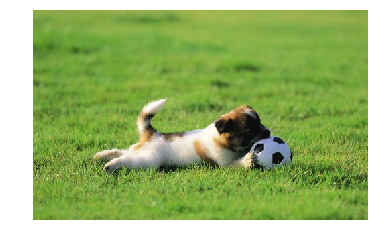

0.10172143720645133


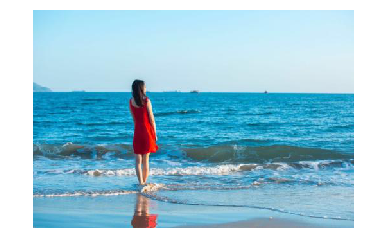

0.02764191412318795


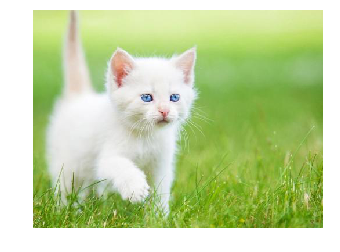

In [7]:
#展示图片
print("\n检索内容：",query)
print("\nTop 5 most similar images:")
counti = 0

for index,row in res_i.iterrows():
    im = mpimg.imread(row["i_path"]) 
    
    counti = counti + 1
    if counti > closest_n:
        continue
    
    print(row["i_score"])
    plt.imshow(im) # 显示图片
    plt.axis('off') # 不显示坐标轴
    plt.show()


In [8]:
#展示视频
print("\n检索内容：",query)
print("\nTop 5 most similar videos:")
countv = 0

for index,row in res_v.iterrows():
    
    countv = countv + 1
    if countv > closest_n:
        continue 
    
    print(row[2])
    print(row[1])
    cap = cv.VideoCapture(row["v_path"])
    FPS = cap.get(cv.CAP_PROP_FPS)
    delay = int(1000/FPS)
    while cap.isOpened():
        ret, frame = cap.read()
        # if frame is read correctly ret is True
        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break
        #blur = cv.GaussianBlur(frame, (0, 0), 5)
        cv.imshow('frame', frame)
        #cv.imshow('blur', blur)
        # press q to exit
        if cv.waitKey(delay) == ord('q'):
            break
    cap.release()
    cv.destroyAllWindows()

print("Finish show")


检索内容： A dog is playing.

Top 5 most similar videos:
0.08315483296097415
a white dog with a red bow tie sitting on a couch .
0.0024347350824925895
a white plate topped with a piece of cake .
Finish show


In [9]:
res_i

,i_path,i_content,i_score
0,E:\大学相关\大学相关（大四春）\major\workspace\images/1.jpg,a dog laying on the grass with a soccer ball .,0.400103
0,E:\大学相关\大学相关（大四春）\major\workspace\images/3.jpg,a woman standing on a beach holding a surfboard .,0.101721
0,E:\大学相关\大学相关（大四春）\major\workspace\images/2.jpg,a white and white cat is sitting in the grass .,0.027642


In [10]:
res_v

,v_path,v_content,v_score
0,E:\大学相关\大学相关（大四春）\major\workspace\videos/1.mp4,a white dog with a red bow tie sitting on a co...,0.083155
0,E:\大学相关\大学相关（大四春）\major\workspace\videos/2.mp4,a white plate topped with a piece of cake .,0.002435
